Imports

In [1]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
import mediapy as media
import cv2
from keras.models import load_model
from keras.callbacks  import EarlyStopping
from keras.callbacks  import ModelCheckpoint
from keras.callbacks  import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

Utils

In [1]:
files_soil = (glob.glob("Data/*soil.png"))
files_tree = (glob.glob("Data/*tree.png"))

print("Total files soil:",len(files_soil))
print("Total files tree:",len(files_tree))

Total files soil: 4448
Total files tree: 2224


## Generating initial dataset

In [2]:
#Generating labels
soil_label = np.zeros(len(files_soil))
soil_tree = np.ones(len(files_tree))

#Adding data format
X = files_soil + files_tree
y = np.hstack((soil_label,soil_tree))

#Spliting in train, test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Printing output data format
print('Train samples: %i with %i Soil samples and %i Tree samples'%(len(X_train),np.sum(y_train),np.sum(1-y_train)))
print('Test samples: %i with %i Soil samples and %i Tree samples'%(len(X_test),np.sum(y_val),np.sum(1-y_test)))
print('Val samples: %i with %i Soil samples and %i Tree samples'%(len(X_val),np.sum(y_val),np.sum(1-y_val)))

Train samples: 5337 with 1782 Soil samples and 3555 Tree samples
Test samples: 668 with 220 Soil samples and 446 Tree samples
Val samples: 667 with 220 Soil samples and 447 Tree samples


Mixed Model

In [7]:
#Getting a custom data augmentation setup 
def get_augmented(x,y,total_samples):
    
    x_aug = []
    y_aug = []
    
    #Minimal data augmentation
    datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,1])
    
    #Getting iteratos
    for i in range(total_samples):
    
        x_partial, y_partial = next(datagen.flow(x,y, batch_size=total_samples))
        x_aug.append(x_partial[0])
        y_aug.append(y_partial[0])
    
    return np.asarray(x_aug), np.asarray(y_aug)

def get_splited_hist(img):
    
    scaler = MinMaxScaler()
    
    b,g,r = cv2.split(img)

    hist_b = cv2.calcHist([b],[0],None,[256],[0,256])
    hist_g = cv2.calcHist([g],[0],None,[256],[0,256])
    hist_r = cv2.calcHist([r],[0],None,[256],[0,256])

    hist_data = hist_b.flatten() + hist_g.flatten() + hist_r.flatten()

    return scaler.fit_transform(hist_data.reshape(-1,1)).flatten()

def data_loader_mixed(paths, labels, batch_size = 5, size_aug = -1, data_augmentation=False):
    
    begin = 0
    end   = batch_size
    
    while True:
        
        partial_x = paths[begin:end]
        out_y = labels[begin:end]
        
        out_x    = []
        out_hist = []
        
        for i in range(len(partial_x)):
            
            img = cv2.imread(partial_x[i])
            
            hist_data = get_splited_hist(img)
            out_hist.append(hist_data)    
                
            img = img/255.0
            out_x.append(img)
            
        if (data_augmentation):
            
            aug_x, aug_y = get_augmented(np.asarray(out_x),out_y,size_aug)
            for img in aug_x: out_x.append(img)
            for img in aug_x: out_hist.append(get_splited_hist(img))
            out_y = np.hstack((out_y,aug_y))
            
        yield [np.asarray(out_x),np.asarray(out_hist)], np.asarray(out_y)
        
        begin = end
        end += batch_size
        
        if (end>=len(paths)):
            
            begin = 0
            end = batch_size
            
train_loader_mixed = data_loader_mixed(X_train, y_train, batch_size = 5, size_aug = 5, data_augmentation=True)
x_data, y = next(train_loader_mixed)
x_data[0].shape,x_data[1].shape,y.shape

Using TensorFlow backend.
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

((10, 50, 50, 3), (10, 256), (10,))

Explainable IA

In [6]:
model = load_model('weights/mixed_model_classifier.h5')

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_base_input (InputLayer)   (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
input_base (Conv2D)             (None, 48, 48, 32)   896         input_base_input[0][0]           
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 48, 48, 32)   0           input_base[0][0]                 
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 46, 46, 16)   4624        max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [420]:
#Loader
STEP_SIZE_TEST=len(X_test)//5
test_loader = data_loader_mixed(X_test, y_test, batch_size = 5)

#Get sample
x_data, y = next(test_loader)
print(y)

idx_sample = 0

img_ = np.asarray([x_data[0][idx_sample]])
hist = np.asarray([x_data[1][idx_sample]])
input_data = [img_,hist]

[0. 0. 0. 0. 0.]


In [421]:
predicts = model.predict(input_data)
print(predicts)
predicts = [0] if predicts[0][0]<0.5 else [1]
predicts = np.asarray(predicts)
predicts

[[0.14565492]]


array([0])

In [422]:
def get_activation(model,input_data,layer_name='conv2d_6'):


    last_conv_layer = model.get_layer(layer_name)
    output = model.output
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input[0],model.input[1]], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([input_data[0],input_data[1]])
    
    for i in range(4):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

In [423]:
heatmap_pl = get_activation(model,input_data,layer_name='conv2d_5')
heatmap_l = get_activation(model,input_data,layer_name='conv2d_6')

heatmap_pl = np.uint8(255 * heatmap_pl)
heatmap_l  = np.uint8(255 * heatmap_l)

heatmap_pl = cv2.applyColorMap(heatmap_pl, cv2.COLORMAP_JET)
heatmap_l = cv2.applyColorMap(heatmap_l, cv2.COLORMAP_JET)

In [424]:
img = input_data[0][0]*255.0
img = img.astype('uint8')
img = cv2.resize(img,(44,44))

In [425]:
hif = .8
superimposed_pl = heatmap_pl * hif + img
superimposed_l = cv2.resize(heatmap_l,(44,44)) * hif + img

heatmaps = np.hstack((superimposed_pl,superimposed_l))

output = 'output.jpeg'
cv2.imwrite(output, heatmaps)

True

In [426]:
output = np.hstack((img,cv2.imread('output.jpeg')))
ratio = 4
output = cv2.resize(output,(output.shape[1]*ratio,output.shape[0]*ratio))

False Positive

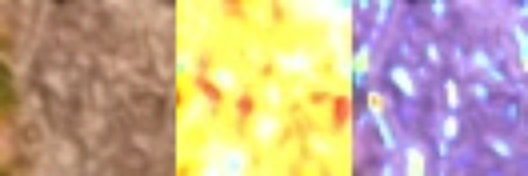

In [427]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='False Positive')

False Positive

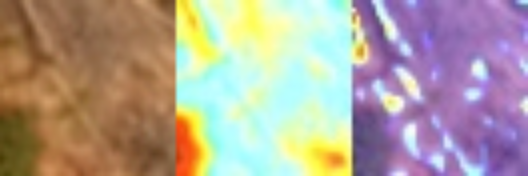

In [418]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='False Positive')

False Positive

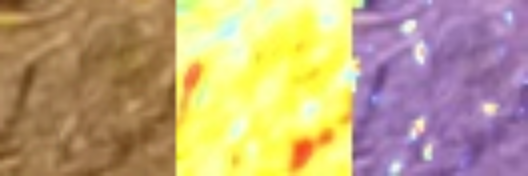

In [410]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='False Positive')

False Positive

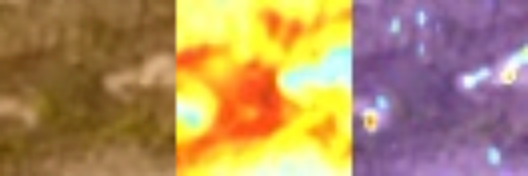

In [398]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='False Positive')

Activation Sample

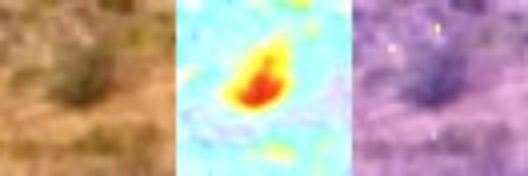

In [365]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='Activation Sample')

Activation Sample

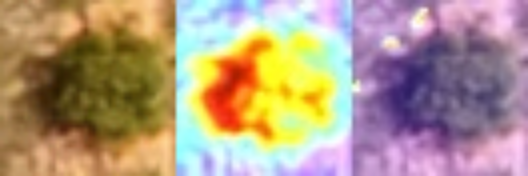

In [346]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='Activation Sample')

Activation Sample

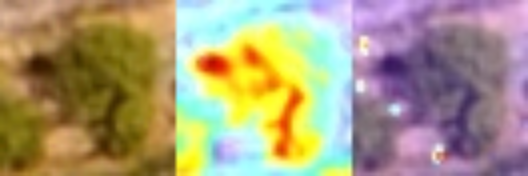

In [337]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='Activation Sample')

Activation Sample

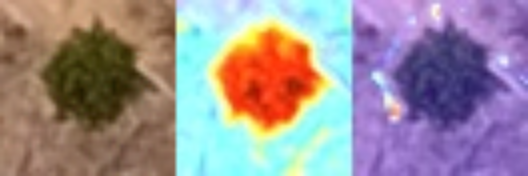

In [327]:
media.show_image(cv2.cvtColor(output.astype('uint8'),cv2.COLOR_BGR2RGB),title='Activation Sample')